## Import libraries

In [28]:
import os
import labels
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Sampler, SubsetRandomSampler
from torch.utils.data import Dataset
from PIL import Image
from PIL import ImageFile
from torchvision import transforms
from tqdm import tqdm  # Import tqdm for progress visualization
from models.cnn_models import SimpleCNN
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
from torchmetrics.functional import confusion_matrix
import seaborn as sns



# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # If using a GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

## Define filepaths as constant

In [29]:
# Define file paths as constants
CSV_FILE_PATH = r'C:\Users\Sandhra George\avalanche\data\dataset.csv'
ROOT_DIR_PATH = r'C:\Users\Sandhra George\avalanche\caxton_dataset\print24'

csv_file = r'C:\Users\Sandhra George\avalanche\data\dataset.csv'  # Path to the CSV file
root_dir = r'C:\Users\Sandhra George\avalanche\caxton_dataset\print24'  # Path to the image directory

## Load data into DataFrame and filter print24

In [30]:
# Load data into a DataFrame for easier processing
data = pd.read_csv(CSV_FILE_PATH)

# Limit dataset to the images between row indices 454 and 7058 (inclusive)
#data_limited = data.iloc[454:7059].reset_index(drop=True)

# Filter the dataset to only include images containing "print24"
data_filtered = data[data.iloc[:, 0].str.contains('print24', na=False)]

# Update the first column to contain only the image filenames
data_filtered.iloc[:, 0] = data_filtered.iloc[:, 0].str.replace(r'.*?/(image-\d+\.jpg)', r'\1', regex=True)

# Display the updated DataFrame
print("First rows of filtered DataFrame:")
print(data_filtered.head())

# Display the last few rows of the updated DataFrame
print("\nLast rows of filtered DataFrame:")
print(data_filtered.tail())

First rows of filtered DataFrame:
          img_path               timestamp  flow_rate  feed_rate  z_offset  \
99496  image-4.jpg  2020-10-07T11:45:35-86        100        100       0.0   
99497  image-5.jpg  2020-10-07T11:45:36-32        100        100       0.0   
99498  image-6.jpg  2020-10-07T11:45:36-79        100        100       0.0   
99499  image-7.jpg  2020-10-07T11:45:37-26        100        100       0.0   
99500  image-8.jpg  2020-10-07T11:45:37-72        100        100       0.0   

       target_hotend  hotend    bed  nozzle_tip_x  nozzle_tip_y  img_num  \
99496          205.0  204.86  64.83           654           560        3   
99497          205.0  204.62  65.08           654           560        4   
99498          205.0  204.62  65.08           654           560        5   
99499          205.0  204.62  65.08           654           560        6   
99500          205.0  204.62  65.08           654           560        7   

       print_id  flow_rate_class  feed_r

## Analysing the target hotend temperature column

In [31]:
# Extract unique temperatures in the 'target_hotend' column and sort them
unique_temperatures = sorted(data_filtered['target_hotend'].unique())  # Sort temperatures in ascending order

# Calculate the full range of temperatures (min and max)
temperature_min = data_filtered['target_hotend'].min()
temperature_max = data_filtered['target_hotend'].max()

# Print the unique temperatures (sorted), count, and full range
print("\nUnique target hotend temperatures in the dataset (sorted):")
print(unique_temperatures)
print(f"\nNumber of unique target hotend temperatures: {len(unique_temperatures)}")
print(f"Temperature range: {temperature_min}° to {temperature_max}°")


Unique target hotend temperatures in the dataset (sorted):
[180.0, 181.0, 182.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 200.0, 201.0, 202.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 230.0]

Number of unique target hotend temperatures: 51
Temperature range: 180.0° to 230.0°


## Create a random temperature sub list

In [32]:
# Check if we have enough unique temperatures to select from
if len(unique_temperatures) >= 50:
    # Select the lowest and highest temperatures
    temperature_sublist = [temperature_min, temperature_max]

    # Remove the lowest and highest temperatures from the unique temperatures list
    remaining_temperatures = [temp for temp in unique_temperatures if temp != temperature_min and temp != temperature_max]

    # Randomly select 40 other temperatures from the remaining ones
    random_temperatures = random.sample(remaining_temperatures, 40)

    # Add the random temperatures to the temperature_sublist
    temperature_sublist.extend(random_temperatures)
    
    # Sort from lowest to highest hotend temperature
    temperature_sublist = sorted(temperature_sublist)

    # Print the temperature sublist
    print("\nTemperature sublist:")
    print(temperature_sublist)
else:
    print("Not enough unique temperatures to select from. At least 40 unique temperatures are required.")


Temperature sublist:
[180.0, 181.0, 182.0, 183.0, 184.0, 186.0, 187.0, 188.0, 189.0, 191.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 201.0, 202.0, 203.0, 205.0, 208.0, 209.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 226.0, 227.0, 228.0, 229.0, 230.0]


## Create a new dataframe with equal class distribution

In [33]:
# Initialise a dictionary to store DataFrames for each class
class_datasets = {}

# Iterate through the filtered dataset to gather class-wise data
for class_id in [0, 1, 2]:  # Ensure we process all classes: 0, 1, 2
    # Filter the data for the current class
    class_data = data_filtered[data_filtered['hotend_class'] == class_id]
    
    if class_data.empty:
        print(f"Class {class_id} dataset size: 0")
    else:
        # Store the data for each class in the dictionary
        class_datasets[class_id] = class_data
        print(f"Class {class_id} dataset size: {len(class_data)}")

# Find the class with the fewest images
min_class_size = min(len(class_datasets[class_id]) for class_id in class_datasets)

# Print the class with the fewest images
print(f"\nSmallest class size: {min_class_size}")

# Now, we will sample the same number of images from each class
balanced_data = []

# Iterate over each class and sample min_class_size images
for class_id in class_datasets:
    class_data = class_datasets[class_id]
    
    # Randomly sample 'min_class_size' images from the class data
    sampled_class_data = class_data.sample(n=min_class_size, random_state=42)
    balanced_data.append(sampled_class_data)

# Combine all the sampled class data into one DataFrame
balanced_dataset = pd.concat(balanced_data).reset_index(drop=True)

# Display the balanced dataset summary
print(f"\nBalanced dataset size: {len(balanced_dataset)}")

# OPTIONAL: Shuffle the final balanced dataset
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first and last five rows of the shuffled dataset
print("\nFirst five rows of the shuffled balanced dataset:")
print(balanced_dataset.head())

print("\nLast five rows of the shuffled balanced dataset:")
print(balanced_dataset.tail())

# Print the count of images in each class after balancing
print("\nNumber of images in each hotend class in the balanced dataset:")
for class_id in [0, 1, 2]:
    class_count = len(balanced_dataset[balanced_dataset['hotend_class'] == class_id])
    print(f"Class {class_id}: {class_count} images")

Class 0 dataset size: 7424
Class 1 dataset size: 11232
Class 2 dataset size: 2492

Smallest class size: 2492

Balanced dataset size: 7476

First five rows of the shuffled balanced dataset:
          img_path               timestamp  flow_rate  feed_rate  z_offset  \
0  image-19089.jpg  2020-10-07T14:13:14-93        148         90      0.03   
1  image-10323.jpg  2020-10-07T13:05:32-49         92        197      0.04   
2   image-3170.jpg  2020-10-07T12:10:07-87         84        151      0.26   
3   image-2130.jpg  2020-10-07T12:02:04-56         75         55      0.00   
4   image-6277.jpg  2020-10-07T12:34:12-00        134         63      0.20   

   target_hotend  hotend    bed  nozzle_tip_x  nozzle_tip_y  img_num  \
0          185.0  185.44  65.28           654           560    19088   
1          206.0  206.25  65.06           654           560    10322   
2          182.0  188.05  65.05           654           560     3169   
3          187.0  187.08  64.92           654         

## Convert balanced_dataset into a dataframe that contains only the img_path and hotend_class

In [34]:
# Assuming the previous steps for balancing the dataset are already done...

# Select only the 'img_path' and 'hotend_class' columns
balanced_dataset_filtered = balanced_dataset[['img_path', 'hotend_class']]

# Display the first few rows of the filtered DataFrame
print("\nFirst five rows of the filtered balanced dataset:")
print(balanced_dataset_filtered.head())

# Display the last few rows of the filtered DataFrame
print("\nLast five rows of the filtered balanced dataset:")
print(balanced_dataset_filtered.tail())

# Optionally, if you want to save this filtered DataFrame to a CSV
#balanced_dataset_filtered.to_csv('balanced_dataset_filtered.csv', index=False)


First five rows of the filtered balanced dataset:
          img_path  hotend_class
0  image-19089.jpg             0
1  image-10323.jpg             1
2   image-3170.jpg             0
3   image-2130.jpg             0
4   image-6277.jpg             0

Last five rows of the filtered balanced dataset:
             img_path  hotend_class
7471   image-8380.jpg             2
7472   image-1401.jpg             2
7473  image-12102.jpg             2
7474   image-3722.jpg             0
7475  image-20837.jpg             2


In [35]:
# Check class distribution in balanced_dataset
class_distribution = balanced_dataset_filtered['hotend_class'].value_counts()
print(class_distribution)

hotend_class
0    2492
1    2492
2    2492
Name: count, dtype: int64


In [36]:
# Print the indices, the classes, and the number of images in each class
for class_label in class_distribution.index:
    # Get all indices for the current class
    class_indices = balanced_dataset_filtered[balanced_dataset_filtered['hotend_class'] == class_label].index.tolist()
    
    # Count the number of images for the current class
    num_images_in_class = len(class_indices)
    
    # Print the details for this class
    print(f"\nClass: {class_label} (Total images: {num_images_in_class})")
    print("Indices: ", class_indices)
    print(f"Number of images in class {class_label}: {num_images_in_class}")

# Step 1: Get the number of unique classes
num_classes = len(class_distribution)

# Step 2: Set a small batch size
small_batch_size = 15  # You can change this to a value like 32, 64, etc.

# Step 3: Calculate the number of samples per class per batch
samples_per_class = small_batch_size // num_classes  # Ensure it's divisible

# Make sure we don't ask for more samples than available in the smallest class
samples_per_class = min(samples_per_class, class_distribution.min())

# Step 4: Calculate the total batch size
batch_size = samples_per_class * num_classes

print(f"\nRecommended Small Batch Size: {batch_size}")
print(f"Samples per class: {samples_per_class}")


Class: 0 (Total images: 2492)
Indices:  [0, 2, 3, 4, 5, 6, 9, 10, 14, 16, 18, 20, 25, 27, 30, 32, 35, 38, 44, 45, 53, 54, 56, 61, 63, 64, 66, 67, 70, 71, 72, 74, 77, 78, 83, 85, 90, 93, 94, 100, 101, 110, 111, 113, 116, 117, 118, 120, 123, 124, 127, 128, 129, 130, 134, 139, 140, 146, 149, 151, 152, 157, 159, 161, 166, 167, 172, 174, 175, 176, 179, 186, 191, 196, 200, 204, 211, 218, 219, 225, 226, 227, 230, 234, 238, 239, 242, 243, 247, 249, 252, 254, 255, 261, 262, 266, 268, 270, 271, 272, 273, 276, 278, 279, 283, 286, 288, 290, 293, 298, 303, 305, 310, 316, 317, 318, 319, 320, 324, 327, 329, 331, 333, 334, 335, 340, 343, 344, 345, 347, 350, 352, 354, 356, 357, 361, 366, 371, 375, 377, 378, 380, 387, 391, 392, 393, 394, 396, 399, 403, 408, 409, 416, 425, 430, 434, 439, 440, 443, 446, 453, 456, 462, 465, 467, 471, 475, 477, 478, 479, 481, 482, 483, 485, 489, 490, 491, 493, 495, 496, 497, 501, 503, 504, 506, 508, 511, 513, 514, 515, 519, 523, 524, 526, 530, 533, 538, 539, 540, 545, 547,

## At this point the balanced dataset has been created

## Create training, validation, and testing datasets

In [37]:
# Number of images in each class (this will be the same after balancing)
num_images_per_class = len(balanced_dataset_filtered) // 3  # since there are 3 classes

# Calculate the number of samples per class
train_size = int(0.8 * num_images_per_class)
valid_size = int(0.1 * num_images_per_class)
test_size = num_images_per_class - train_size - valid_size

# Sample indices for each class
train_indices = []
valid_indices = []
test_indices = []

for class_label in [0, 1, 2]:
    class_data = balanced_dataset_filtered[balanced_dataset_filtered['hotend_class'] == class_label].index.tolist()
    
    # Shuffle the indices of the current class
    random.shuffle(class_data)
    
    # Split the indices for each class into train, validation, and test
    train_indices.extend(class_data[:train_size])
    valid_indices.extend(class_data[train_size:train_size + valid_size])
    test_indices.extend(class_data[train_size + valid_size:])

# Sort the indices of the training, validation, and test datasets to ensure consistent and ordered processing
train_indices = sorted(train_indices)
valid_indices = sorted(valid_indices)
test_indices = sorted(test_indices)

# Class distribution in train, validation, and test sets
train_class_distribution = [0, 0, 0]
valid_class_distribution = [0, 0, 0]
test_class_distribution = [0, 0, 0]

for index in train_indices:
    class_label = balanced_dataset_filtered.loc[index, 'hotend_class']
    train_class_distribution[class_label] += 1

for index in valid_indices:
    class_label = balanced_dataset_filtered.loc[index, 'hotend_class']
    valid_class_distribution[class_label] += 1

for index in test_indices:
    class_label = balanced_dataset_filtered.loc[index, 'hotend_class']
    test_class_distribution[class_label] += 1

# Print the class distribution
print("Train set class distribution:", train_class_distribution)
print("Validation set class distribution:", valid_class_distribution)
print("Test set class distribution:", test_class_distribution)

# Verify lengths
print("Train set size:", len(train_indices))
print("Validation set size:", len(valid_indices))
print("Test set size:", len(test_indices))

Train set class distribution: [1993, 1993, 1993]
Validation set class distribution: [249, 249, 249]
Test set class distribution: [250, 250, 250]
Train set size: 5979
Validation set size: 747
Test set size: 750


In [38]:
# Create DataFrames for train, validation, and test sets based on the indices
train_data = balanced_dataset_filtered.iloc[train_indices].reset_index(drop=True)
val_data = balanced_dataset_filtered.iloc[valid_indices].reset_index(drop=True)
test_data = balanced_dataset_filtered.iloc[test_indices].reset_index(drop=True)

# Optionally print the first few rows to verify
print("Train DataFrame sample:")
print(train_data.head())

print("Validation DataFrame sample:")
print(val_data.head())

print("Test DataFrame sample:")
print(test_data.head())

Train DataFrame sample:
          img_path  hotend_class
0  image-19089.jpg             0
1  image-10323.jpg             1
2   image-6277.jpg             0
3  image-19945.jpg             0
4  image-16946.jpg             0
Validation DataFrame sample:
          img_path  hotend_class
0   image-3170.jpg             0
1   image-4689.jpg             0
2   image-1677.jpg             2
3   image-1688.jpg             2
4  image-13683.jpg             0
Test DataFrame sample:
          img_path  hotend_class
0   image-2130.jpg             0
1  image-19192.jpg             0
2  image-20143.jpg             0
3  image-22545.jpg             1
4  image-23153.jpg             1


## Check for Missing or Invalid Labels in Training, Validation, and Test Data

In [39]:
# Check for any missing labels or invalid labels
print(train_data['hotend_class'].isnull().sum())  # Count missing labels
print(train_data['hotend_class'].unique())  # Check unique labels to ensure there are no unexpected values

# Check for any missing labels or invalid labels
print(val_data['hotend_class'].isnull().sum())  # Count missing labels
print(val_data['hotend_class'].unique())  # Check unique labels to ensure there are no unexpected values
# Check for any missing labels or invalid labels
print(test_data['hotend_class'].isnull().sum())  # Count missing labels
print(test_data['hotend_class'].unique())  # Check unique labels to ensure there are no unexpected values

0
[0 1 2]
0
[0 2 1]
0
[0 1 2]


## Balanced Dataset class

In [40]:
# Define the dataset class
class BalancedDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data = data_frame
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Validate that the images exist in the directory
        self.valid_indices = self.get_valid_indices()

    def get_valid_indices(self):
        valid_indices = []
        for idx in tqdm(range(len(self.data)), desc="Validating images"):
            img_name = self.data.iloc[idx, 0].strip()
            img_name = img_name.split('/')[-1]  # Extract file name
            
            if img_name.startswith("image-"):
                try:
                    # Ensure we only include images in the valid range
                    image_number = int(img_name.split('-')[1].split('.')[0])
                    if 4 <= image_number <= 26637:
                        full_img_path = os.path.join(self.root_dir, img_name)
                        if os.path.exists(full_img_path):
                            valid_indices.append(idx)
                        else:
                            print(f"Image does not exist: {full_img_path}")
                except ValueError:
                    print(f"Invalid filename format for {img_name}. Skipping...")
        
        print(f"Total valid indices found: {len(valid_indices)}")  # Debugging output
        return valid_indices

    def __len__(self):
            return len(self.valid_indices)
    
    def __getitem__(self, idx):
        # Wrap around the index if it exceeds the length of valid indices
        idx = idx % len(self.valid_indices)
        
        # Get the actual index from valid indices
        actual_idx = self.valid_indices[idx]
        img_name = self.data.iloc[actual_idx, 0].strip()
        full_img_path = os.path.join(self.root_dir, img_name)
    
        try:
            # Attempt to open the image and convert to RGB
            image = Image.open(full_img_path).convert('RGB')
    
            # Fetch the label and convert it to an integer
            label_str = self.data.iloc[actual_idx]['hotend_class']  # Use column name 'hotend_class'
            label = int(label_str)  # Ensure label is integer
    
            # Apply transformations if defined
            if self.transform:
                image = self.transform(image)
    
            return image, label, actual_idx
        except (OSError, IOError, ValueError) as e:
            # Print error message for debugging
            print(f"Error loading image {full_img_path}: {e}")
    
            # Handle gracefully by skipping the corrupted/missing file
            # Fetch the next valid index (recursively handle until a valid image is found)
            return self.__getitem__((idx + 1) % len(self.valid_indices))

## Balanced Batch Sampler class

In [41]:
class BalancedBatchSampler(Sampler):
    def __init__(self, data_frame, batch_size=15, samples_per_class=5):
        """
        data_frame: Pandas DataFrame with image paths and their respective class labels.
        batch_size: Total batch size.
        samples_per_class: Number of samples to draw from each class per batch.
        """
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.samples_per_class = samples_per_class
        self.num_classes = len(data_frame['hotend_class'].unique())
        
        if self.batch_size % self.num_classes != 0:
            raise ValueError("Batch size must be divisible by the number of classes.")

        self.class_indices = {
            class_id: self.data_frame[self.data_frame['hotend_class'] == class_id].index.tolist()
            for class_id in self.data_frame['hotend_class'].unique()
        }
        
        # Shuffle class indices initially
        for class_id in self.class_indices:
            random.shuffle(self.class_indices[class_id])

        self.num_samples_per_epoch = sum(len(indices) for indices in self.class_indices.values())
        self.indices_used = {class_id: [] for class_id in self.class_indices}

    def __iter__(self):
        batches = []

        # Replenish indices for each class
        for class_id in self.class_indices:
            if not self.class_indices[class_id]:
                raise ValueError(f"Class {class_id} has no samples. Cannot form balanced batches.")

            # Shuffle and use all indices from this class
            self.indices_used[class_id] = self.class_indices[class_id].copy()
            random.shuffle(self.indices_used[class_id])

        # Generate balanced batches
        while len(batches) * self.batch_size < self.num_samples_per_epoch:
            batch = []
            for class_id in self.indices_used:
                if len(self.indices_used[class_id]) < self.samples_per_class:
                    # If a class runs out of samples, reshuffle and replenish
                    self.indices_used[class_id] = self.class_indices[class_id].copy()
                    random.shuffle(self.indices_used[class_id])

                # Take `samples_per_class` indices from the current class
                batch.extend(self.indices_used[class_id][:self.samples_per_class])
                self.indices_used[class_id] = self.indices_used[class_id][self.samples_per_class:]

            # Shuffle the batch and append
            random.shuffle(batch)
            batches.append(batch)

        return iter(batches)

    def __len__(self):
        # Total number of batches per epoch
        return self.num_samples_per_epoch // self.batch_size

In [42]:
# Create the dataset instance (make sure to provide the right data_frame and root directory)
train_dataset = BalancedDataset(data_frame=train_data, root_dir=root_dir)
val_dataset = BalancedDataset(data_frame=val_data, root_dir=root_dir)
test_dataset = BalancedDataset(data_frame=test_data, root_dir=root_dir)

# Create the sampler (pass the DataFrame instead of the dataset)
train_sampler = BalancedBatchSampler(data_frame=train_data, batch_size=15, samples_per_class=5)
val_sampler = BalancedBatchSampler(data_frame=val_data, batch_size=15, samples_per_class=5)
test_sampler = BalancedBatchSampler(data_frame=test_data, batch_size=15, samples_per_class=5)

# Create the DataLoader with the sampler
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, shuffle = False)

# For validation and testing, we typically don't need a batch_sampler, so use regular batching
val_loader = DataLoader(val_dataset, batch_sampler=val_sampler, shuffle = False)  # or any batch size that makes sense
test_loader = DataLoader(test_dataset, batch_sampler=test_sampler)  # same as above

print(f"Train dataset length: {len(train_loader.dataset)}")
print(f"Validation dataset length: {len(val_loader.dataset)}")
print(f"Test dataset length: {len(test_loader.dataset)}")

Validating images: 100%|██████████| 5979/5979 [00:00<00:00, 6882.89it/s]


Total valid indices found: 5979


Validating images: 100%|██████████| 747/747 [00:00<00:00, 6861.27it/s]


Total valid indices found: 747


Validating images: 100%|██████████| 750/750 [00:00<00:00, 9711.70it/s]

Total valid indices found: 750
Train dataset length: 5979
Validation dataset length: 747
Test dataset length: 750


## Check the class distribution of randomly selected batches in train loader

In [43]:
# Function to print random batches and their class distribution
def print_random_batches(train_loader, num_batches=5):
    for _ in range(num_batches):
        # Get the next batch from the loader
        batch_images, batch_labels, _ = next(iter(train_loader))  # Get the images, labels, and indices (if needed)
        
        # Calculate the class distribution in this batch
        class_distribution = Counter(batch_labels.tolist())  # Convert tensor to list for counting
        
        # Print the class distribution for the current batch
        print(f"Class distribution for this batch: {dict(class_distribution)}")
        
        # Print the actual labels for the batch (as a list or tensor)
        print("Actual labels for this batch:")
        print(batch_labels.tolist())  # Converts tensor to list for readability
        
        # Print the image tensor shape for the batch
        print("Image tensor shape for the batch:")
        print(batch_images.shape)  # This prints the shape of the image tensor
        
        # Optionally, print a few details of the image tensors (e.g., min and max values) to understand them
        print("Min and max values of the image tensors:")
        print(f"Min: {batch_images.min()}, Max: {batch_images.max()}")
        
        # If you want to print the image itself (assuming it's a small size, for visualization)
        # You can use something like matplotlib to visualize the images, for example:
        # from matplotlib import pyplot as plt
        # plt.imshow(batch_images[0].permute(1, 2, 0).numpy())  # assuming 3 channel images
        # plt.show()
        
        print("-" * 50)

# Print random batches and their class distribution
print_random_batches(train_loader, num_batches=5)

Class distribution for this batch: {2: 5, 1: 5, 0: 5}
Actual labels for this batch:
[2, 1, 2, 1, 0, 1, 1, 0, 2, 0, 2, 0, 2, 1, 0]
Image tensor shape for the batch:
torch.Size([15, 3, 224, 224])
Min and max values of the image tensors:
Min: -2.1179039478302, Max: 2.640000104904175
--------------------------------------------------
Class distribution for this batch: {2: 5, 1: 5, 0: 5}
Actual labels for this batch:
[2, 2, 1, 2, 1, 0, 2, 1, 0, 0, 2, 0, 1, 1, 0]
Image tensor shape for the batch:
torch.Size([15, 3, 224, 224])
Min and max values of the image tensors:
Min: -1.9809060096740723, Max: 2.640000104904175
--------------------------------------------------
Class distribution for this batch: {0: 5, 1: 5, 2: 5}
Actual labels for this batch:
[0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 2, 1, 1, 2, 1]
Image tensor shape for the batch:
torch.Size([15, 3, 224, 224])
Min and max values of the image tensors:
Min: -2.1179039478302, Max: 2.640000104904175
--------------------------------------------------
C

## Check class distribution of random batches from training, validation and testing data

In [44]:
def print_label_batch_from_loader(loader, dataset_name):
    """Fetch and print a batch of labels from the data loader."""
    data_iter = iter(loader)
    batch_images, batch_labels, _ = next(data_iter)  # Get one batch (including the index)
    
    print(f"\n{dataset_name} - Sample Label Batch:")
    print(batch_labels)  # Print the labels for the batch
    
    # Optionally, you can convert the tensor labels to a list for easier reading:
    print(f"Labels as list: {batch_labels.tolist()}")

# Print batches of labels from the train, validation, and test loaders
print_label_batch_from_loader(train_loader, 'Training')
print_label_batch_from_loader(val_loader, 'Validation')
print_label_batch_from_loader(test_loader, 'Test')


Training - Sample Label Batch:
tensor([1, 0, 0, 2, 1, 0, 2, 1, 2, 1, 1, 2, 2, 0, 0])
Labels as list: [1, 0, 0, 2, 1, 0, 2, 1, 2, 1, 1, 2, 2, 0, 0]

Validation - Sample Label Batch:
tensor([1, 2, 1, 2, 2, 1, 2, 0, 2, 1, 0, 1, 0, 0, 0])
Labels as list: [1, 2, 1, 2, 2, 1, 2, 0, 2, 1, 0, 1, 0, 0, 0]

Test - Sample Label Batch:
tensor([1, 1, 1, 0, 1, 1, 0, 2, 0, 2, 0, 2, 2, 2, 0])
Labels as list: [1, 1, 1, 0, 1, 1, 0, 2, 0, 2, 0, 2, 2, 2, 0]


## Display a Random Image from the Dataset with Its Label

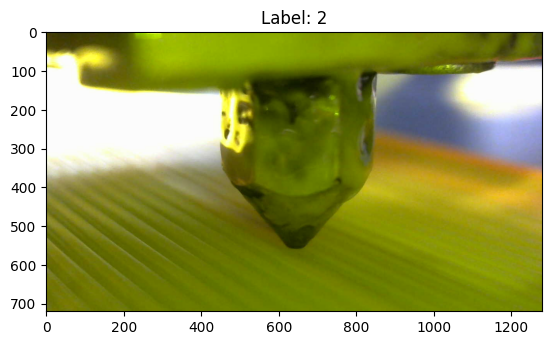

C:\Users\Sandhra George\avalanche\caxton_dataset\print24\image-5090.jpg
C:\Users\Sandhra George\avalanche\caxton_dataset\print24\image-5090.jpg


In [45]:
import matplotlib.pyplot as plt
import random

# Assume 'train_data' is your DataFrame with image paths and labels
random_index = random.choice(train_data.index)  # Choose a random index
img_path = os.path.join(root_dir, train_data.iloc[random_index, 0])
label = train_data.loc[random_index, 'hotend_class']

# Load the image
img = plt.imread(img_path)  # Use appropriate image loading method

# Plot the image and display the label
plt.imshow(img)
plt.title(f"Label: {label}")
plt.show()
print(img_path)
print(img_path)

In [46]:
# Ensure that image paths and labels are correctly aligned

# First image
first_index = train_data.index[0]
first_image = train_data.loc[first_index, 'img_path']
first_label = train_data.loc[first_index, 'hotend_class']
print(f"First Image Path: {first_image}, First Label: {first_label}")

# Last image
last_index = train_data.index[-1]  # Accessing the last index
last_image = train_data.loc[last_index, 'img_path']
last_label = train_data.loc[last_index, 'hotend_class']
print(f"Last Image Path: {last_image}, Last Label: {last_label}")


First Image Path: image-19089.jpg, First Label: 0
Last Image Path: image-20837.jpg, Last Label: 2


## Printing Class Distribution for Training, Validation, and Test Data

In [47]:
# Function to print class distribution
def print_class_distribution(loader, dataset_name):
    """Print class distribution in the dataset."""
    all_labels = []

    # Collect all labels from the dataset
    for batch in loader:
        if len(batch) == 2:  # Normal batch with (image, label)
            _, labels = batch
        elif len(batch) == 3:  # Batch with (image, label, idx) from BalancedDataset
            _, labels, _ = batch
        
        # Collect labels from the batch
        all_labels.extend(labels.cpu().numpy())  # Collect labels and move them to CPU if using GPU

    # Calculate and print the class distribution
    class_counts = Counter(all_labels)
    print(f"\n{dataset_name} Class Distribution:")
    for class_id, count in class_counts.items():
        print(f"Class {class_id}: {count} samples")

# Print class distribution for train, validation, and test data
print_class_distribution(train_loader, 'Training')
print_class_distribution(val_loader, 'Validation')
print_class_distribution(test_loader, 'Test')


Training Class Distribution:
Class 0: 1995 samples
Class 2: 1995 samples
Class 1: 1995 samples

Validation Class Distribution:
Class 1: 250 samples
Class 2: 250 samples
Class 0: 250 samples

Test Class Distribution:
Class 2: 250 samples
Class 0: 250 samples
Class 1: 250 samples


## Model Training, Validation, and Testing with Class Distribution and Learning Rate Scheduling

In [ ]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model = SimpleCNN(num_classes=3).to(device)

# Training parameters
num_epochs = 10  # Adjust as needed
class_weights = torch.tensor([1.0, 1.0, 1.0]).to(device)  # Update these based on your class distribution
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Adjust learning rate if needed
# **Add the learning rate scheduler here**
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Decrease LR every 10 epochs by a factor of 0.1

# Initialize confusion matrix trackers
num_classes = 3
train_cm = ConfusionMatrix(task='multiclass', num_classes=num_classes).to(device)
val_cm = ConfusionMatrix(task='multiclass',num_classes=num_classes).to(device)

best_val_accuracy = 0.0  # Track the best validation accuracy to save the best model

# Store losses for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    class_counts = [0] * 3  # Assuming 3 classes, update if needed

    # Training phase with tqdm progress bar
    for images, labels, _ in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        print(f"Outputs (Raw): {outputs}")  # Log raw outputs
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        # Update confusion matrix
        train_cm.update(predicted, labels)

        # Update class counts
        for label in labels:
            class_counts[label.item()] += 1
        
        # Print predicted vs actual labels for each batch
        for i in range(len(labels)):
            print(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")
    
    # Print class distribution during training
    print(f"Training Class Distribution: {class_counts}")
    
    # **Call the scheduler here at the end of each epoch to update the learning rate**
    scheduler.step()

    # Store training loss for plotting
    train_losses.append(epoch_loss)
    
    # Compute and plot confusion matrix for training
    cm_train = train_cm.compute()
    print(f"Training Confusion Matrix:\n{cm_train}")
    sns.heatmap(cm_train.cpu().numpy(), annot=True, fmt="d", cmap="Blues", 
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Training Confusion Matrix - Epoch {epoch + 1}')
    plt.show()

    train_cm.reset()  # Reset confusion matrix tracker for next epoch
    print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")

    # Validation phase with tqdm progress bar
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    val_class_counts = [0] * 3  # Assuming 3 classes, update if needed

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels, _ in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            print(f"Outputs (Raw): {outputs}")  # Log raw outputs
            loss = criterion(outputs, labels)

            # Track validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)
            
            # Update confusion matrix
            val_cm.update((predicted, labels))

            # Update class counts for validation
            for label in labels:
                val_class_counts[label.item()] += 1

            # Print predicted vs actual labels for each batch
            for i in range(len(labels)):
                print(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")

    val_epoch_loss = val_loss / val_total_samples
    val_epoch_accuracy = val_correct_predictions / val_total_samples
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")
    
    # Print class distribution during validation
    print(f"Validation Class Distribution: {val_class_counts}")

    # Store validation loss for plotting
    val_losses.append(val_epoch_loss)
    
    # Compute and plot confusion matrix for validation
    cm_val = val_cm.compute()
    print(f"Validation Confusion Matrix:\n{cm_val}")
    sns.heatmap(cm_val.cpu().numpy(), annot=True, fmt="d", cmap="Blues", 
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Validation Confusion Matrix - Epoch {epoch + 1}')
    plt.show()

    val_cm.reset()  # Reset confusion matrix tracker for next epoch
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

    # Save the model if it achieves better validation accuracy
    if val_epoch_accuracy > best_val_accuracy:
        best_val_accuracy = val_epoch_accuracy
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print("Saved the model with improved validation accuracy.")

# End of training loop
print("Training complete.")

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Test model function with tqdm progress bar
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    test_class_counts = [0] * 3  # Assuming 3 classes, update if needed
    with torch.no_grad():  # Disable gradients for testing
        for images, labels, _ in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Update class counts for testing
            for label in labels:
                test_class_counts[label.item()] += 1

            # Print predicted vs actual labels for each batch
            for i in range(len(labels)):
                print(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")

    avg_accuracy = correct_predictions / total_samples
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    
    # Print class distribution during testing
    print(f"Test Class Distribution: {test_class_counts}")

# Run the test phase after training
test_model(model, test_loader)


Epoch 1/10


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Outputs (Raw): tensor([[-0.0864,  0.0114,  0.0452],
        [-0.0897,  0.0132,  0.0434],
        [-0.0936,  0.0099,  0.0476],
        [-0.0929,  0.0123,  0.0444],
        [-0.0945,  0.0178,  0.0469],
        [-0.0926,  0.0146,  0.0432],
        [-0.0936,  0.0157,  0.0447],
        [-0.0911,  0.0158,  0.0449],
        [-0.0868,  0.0116,  0.0456],
        [-0.0917,  0.0158,  0.0465],
        [-0.0952,  0.0192,  0.0487],
        [-0.0927,  0.0134,  0.0458],
        [-0.0846,  0.0108,  0.0445],
        [-0.0917,  0.0107,  0.0452],
        [-0.0901,  0.0170,  0.0494]], grad_fn=<AddmmBackward0>)


Training:   0%|          | 1/398 [00:01<07:33,  1.14s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0881,  0.0160,  0.0479],
        [-0.0873,  0.0139,  0.0440],
        [-0.0926,  0.0175,  0.0460],
        [-0.0876,  0.0089,  0.0443],
        [-0.0867,  0.0129,  0.0481],
        [-0.0875,  0.0167,  0.0462],
        [-0.0894,  0.0124,  0.0475],
        [-0.0910,  0.0119,  0.0421],
        [-0.0858,  0.0148,  0.0478],
        [-0.0864,  0.0059,  0.0446],
        [-0.0890,  0.0109,  0.0431],
        [-0.0871,  0.0078,  0.0457],
        [-0.0900,  0.0156,  0.0448],
        [-0.0882,  0.0101,  0.0428],
        [-0.0858,  0.0132,  0.0462]], grad_fn=<AddmmBackward0>)


Training:   1%|          | 2/398 [00:02<07:50,  1.19s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-0.0877,  0.0180,  0.0490],
        [-0.0858,  0.0073,  0.0433],
        [-0.0838,  0.0083,  0.0407],
        [-0.0827,  0.0044,  0.0427],
        [-0.0850,  0.0087,  0.0467],
        [-0.0876,  0.0111,  0.0434],
        [-0.0859,  0.0083,  0.0396],
        [-0.0853,  0.0083,  0.0480],
        [-0.0849,  0.0130,  0.0433],
        [-0.0813,  0.0071,  0.0434],
        [-0.0840,  0.0130,  0.0462],
        [-0.0787,  0.0005,  0.0401],
        [-0.0837,  0.0111,  0.0463],
        [-0.0770,  0.0017,  0.0435],
        [-0.0784,  0.0010,  0.0416]], grad_fn=<AddmmBackward0>)


Training:   1%|          | 3/398 [00:04<09:18,  1.41s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-0.0790,  0.0053,  0.0430],
        [-0.0795,  0.0085,  0.0394],
        [-0.0829,  0.0160,  0.0461],
        [-0.0811,  0.0016,  0.0433],
        [-0.0799,  0.0027,  0.0428],
        [-0.0799,  0.0084,  0.0470],
        [-0.0814,  0.0118,  0.0487],
        [-0.0797,  0.0035,  0.0418],
        [-0.0819,  0.0085,  0.0396],
        [-0.0766,  0.0015,  0.0444],
        [-0.0813,  0.0118,  0.0440],
        [-0.0800,  0.0118,  0.0458],
        [-0.0830,  0.0082,  0.0465],
        [-0.0796,  0.0131,  0.0486],
        [-0.0826,  0.0046,  0.0426]], grad_fn=<AddmmBackward0>)


Training:   1%|          | 4/398 [00:05<08:42,  1.33s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-0.0784,  0.0123,  0.0452],
        [-0.0733,  0.0062,  0.0417],
        [-0.0708, -0.0011,  0.0395],
        [-0.0781,  0.0048,  0.0438],
        [-0.0786,  0.0148,  0.0474],
        [-0.0793,  0.0109,  0.0450],
        [-0.0795,  0.0059,  0.0447],
        [-0.0776,  0.0054,  0.0437],
        [-0.0784,  0.0041,  0.0428],
        [-0.0786,  0.0028,  0.0417],
        [-0.0801,  0.0049,  0.0430],
        [-0.0816,  0.0022,  0.0431],
        [-0.0786,  0.0052,  0.0422],
        [-0.0781,  0.0098,  0.0432],
        [-0.0817,  0.0029,  0.0442]], grad_fn=<AddmmBackward0>)


Training:   1%|▏         | 5/398 [00:06<09:33,  1.46s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-0.0763,  0.0047,  0.0417],
        [-0.0709,  0.0060,  0.0411],
        [-0.0748,  0.0063,  0.0437],
        [-0.0728,  0.0139,  0.0453],
        [-0.0711,  0.0052,  0.0386],
        [-0.0746,  0.0085,  0.0442],
        [-0.0751,  0.0077,  0.0430],
        [-0.0761,  0.0130,  0.0390],
        [-0.0729, -0.0007,  0.0421],
        [-0.0747,  0.0122,  0.0387],
        [-0.0700,  0.0002,  0.0416],
        [-0.0750,  0.0130,  0.0426],
        [-0.0745,  0.0101,  0.0435],
        [-0.0744,  0.0034,  0.0445],
        [-0.0690,  0.0088,  0.0426]], grad_fn=<AddmmBackward0>)


Training:   2%|▏         | 6/398 [00:08<09:51,  1.51s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-0.0736,  0.0116,  0.0418],
        [-0.0681,  0.0042,  0.0430],
        [-0.0696,  0.0051,  0.0435],
        [-0.0728,  0.0018,  0.0421],
        [-0.0733,  0.0075,  0.0399],
        [-0.0710,  0.0063,  0.0424],
        [-0.0736,  0.0158,  0.0433],
        [-0.0720,  0.0042,  0.0408],
        [-0.0731,  0.0157,  0.0427],
        [-0.0699,  0.0026,  0.0387],
        [-0.0708,  0.0052,  0.0429],
        [-0.0724,  0.0103,  0.0407],
        [-0.0625,  0.0001,  0.0403],
        [-0.0731,  0.0112,  0.0413],
        [-0.0737,  0.0138,  0.0419]], grad_fn=<AddmmBackward0>)


Training:   2%|▏         | 7/398 [00:10<10:07,  1.55s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-0.0738,  0.0074,  0.0411],
        [-0.0659,  0.0036,  0.0393],
        [-0.0695,  0.0070,  0.0424],
        [-0.0681,  0.0029,  0.0344],
        [-0.0691,  0.0099,  0.0410],
        [-0.0646,  0.0045,  0.0365],
        [-0.0616,  0.0006,  0.0393],
        [-0.0670,  0.0154,  0.0387],
        [-0.0673,  0.0035,  0.0364],
        [-0.0682,  0.0038,  0.0352],
        [-0.0702,  0.0058,  0.0427],
        [-0.0662,  0.0119,  0.0414],
        [-0.0659,  0.0041,  0.0403],
        [-0.0685,  0.0077,  0.0392],
        [-0.0569, -0.0018,  0.0406]], grad_fn=<AddmmBackward0>)


Training:   2%|▏         | 8/398 [00:11<10:16,  1.58s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0620,  0.0118,  0.0402],
        [-0.0621, -0.0033,  0.0374],
        [-0.0663,  0.0114,  0.0380],
        [-0.0605, -0.0012,  0.0366],
        [-0.0629,  0.0030,  0.0391],
        [-0.0628,  0.0008,  0.0344],
        [-0.0629,  0.0052,  0.0376],
        [-0.0665,  0.0007,  0.0373],
        [-0.0654,  0.0113,  0.0400],
        [-0.0572, -0.0037,  0.0342],
        [-0.0622,  0.0070,  0.0363],
        [-0.0586, -0.0030,  0.0353],
        [-0.0644,  0.0136,  0.0404],
        [-0.0630,  0.0054,  0.0387],
        [-0.0587,  0.0079,  0.0371]], grad_fn=<AddmmBackward0>)


Training:   2%|▏         | 9/398 [00:13<10:35,  1.63s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-0.0527, -0.0040,  0.0347],
        [-0.0629,  0.0018,  0.0363],
        [-0.0608,  0.0092,  0.0392],
        [-0.0630,  0.0079,  0.0393],
        [-0.0570,  0.0054,  0.0366],
        [-0.0586,  0.0079,  0.0376],
        [-0.0610,  0.0110,  0.0378],
        [-0.0630,  0.0112,  0.0359],
        [-0.0624,  0.0119,  0.0385],
        [-0.0629,  0.0113,  0.0376],
        [-0.0586,  0.0004,  0.0336],
        [-0.0642, -0.0017,  0.0372],
        [-0.0659,  0.0037,  0.0372],
        [-0.0619,  0.0060,  0.0363],
        [-0.0554,  0.0030,  0.0380]], grad_fn=<AddmmBackward0>)


Training:   3%|▎         | 10/398 [00:15<10:24,  1.61s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0600,  0.0022,  0.0368],
        [-0.0580,  0.0048,  0.0376],
        [-0.0560, -0.0050,  0.0326],
        [-0.0534,  0.0008,  0.0295],
        [-0.0552,  0.0118,  0.0320],
        [-0.0597,  0.0024,  0.0361],
        [-0.0522,  0.0024,  0.0337],
        [-0.0590,  0.0056,  0.0390],
        [-0.0516,  0.0038,  0.0332],
        [-0.0562,  0.0017,  0.0329],
        [-0.0571, -0.0005,  0.0412],
        [-0.0576,  0.0034,  0.0350],
        [-0.0587,  0.0104,  0.0367],
        [-0.0585,  0.0107,  0.0361],
        [-0.0593,  0.0086,  0.0365]], grad_fn=<AddmmBackward0>)


Training:   3%|▎         | 11/398 [00:16<10:04,  1.56s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0539, -0.0002,  0.0392],
        [-0.0522,  0.0106,  0.0351],
        [-0.0537,  0.0080,  0.0374],
        [-0.0549,  0.0038,  0.0293],
        [-0.0524, -0.0066,  0.0303],
        [-0.0495,  0.0066,  0.0316],
        [-0.0438, -0.0044,  0.0354],
        [-0.0496, -0.0003,  0.0295],
        [-0.0534,  0.0064,  0.0352],
        [-0.0548,  0.0059,  0.0337],
        [-0.0510,  0.0011,  0.0315],
        [-0.0500,  0.0021,  0.0327],
        [-0.0536,  0.0034,  0.0322],
        [-0.0547,  0.0075,  0.0317],
        [-0.0564,  0.0008,  0.0349]], grad_fn=<AddmmBackward0>)


Training:   3%|▎         | 12/398 [00:18<09:53,  1.54s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-4.1761e-02, -5.9223e-03,  3.2832e-02],
        [-5.3986e-02,  7.4424e-04,  3.3217e-02],
        [-4.7274e-02,  1.5007e-03,  3.1454e-02],
        [-5.0129e-02,  2.0316e-03,  3.1954e-02],
        [-4.2791e-02, -1.3439e-03,  3.7952e-02],
        [-4.9430e-02,  3.7255e-03,  3.3249e-02],
        [-4.8128e-02, -2.1867e-06,  3.3492e-02],
        [-4.8716e-02,  1.7995e-03,  3.1487e-02],
        [-5.2441e-02,  1.6517e-03,  3.5616e-02],
        [-5.5000e-02, -1.4640e-04,  3.2640e-02],
        [-4.6377e-02,  9.9145e-04,  2.9195e-02],
        [-5.1166e-02,  7.1558e-03,  3.4091e-02],
        [-5.1467e-02,  5.4579e-03,  3

Training:   3%|▎         | 13/398 [00:19<09:45,  1.52s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0469,  0.0050,  0.0288],
        [-0.0487,  0.0011,  0.0363],
        [-0.0435, -0.0063,  0.0298],
        [-0.0382, -0.0041,  0.0294],
        [-0.0521, -0.0004,  0.0339],
        [-0.0462,  0.0004,  0.0323],
        [-0.0449, -0.0007,  0.0279],
        [-0.0394, -0.0006,  0.0279],
        [-0.0445, -0.0036,  0.0302],
        [-0.0454, -0.0029,  0.0253],
        [-0.0386, -0.0007,  0.0272],
        [-0.0430, -0.0053,  0.0307],
        [-0.0463, -0.0021,  0.0332],
        [-0.0415, -0.0043,  0.0283],
        [-0.0455,  0.0017,  0.0331]], grad_fn=<AddmmBackward0>)


Training:   4%|▎         | 14/398 [00:20<09:35,  1.50s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-4.2844e-02, -4.6592e-03,  3.2099e-02],
        [-4.0015e-02,  8.5612e-04,  2.5289e-02],
        [-4.2578e-02, -4.9827e-03,  3.0505e-02],
        [-3.6049e-02, -6.3531e-05,  2.7014e-02],
        [-4.1099e-02, -6.8885e-03,  3.4778e-02],
        [-4.1107e-02, -7.9632e-04,  3.4913e-02],
        [-4.6955e-02, -1.4335e-03,  3.1979e-02],
        [-4.0693e-02,  6.7368e-05,  2.2800e-02],
        [-4.2342e-02,  2.4933e-03,  2.9073e-02],
        [-3.4227e-02, -5.6029e-03,  3.3733e-02],
        [-4.3528e-02, -1.8711e-03,  3.2567e-02],
        [-4.6593e-02, -4.2794e-03,  2.7219e-02],
        [-4.7879e-02, -1.0882e-03,  3

Training:   4%|▍         | 15/398 [00:22<09:31,  1.49s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0396, -0.0040,  0.0273],
        [-0.0397,  0.0002,  0.0245],
        [-0.0393, -0.0022,  0.0226],
        [-0.0443,  0.0034,  0.0276],
        [-0.0338, -0.0061,  0.0271],
        [-0.0395, -0.0051,  0.0297],
        [-0.0418, -0.0009,  0.0255],
        [-0.0368, -0.0008,  0.0255],
        [-0.0423, -0.0081,  0.0261],
        [-0.0405, -0.0053,  0.0298],
        [-0.0370, -0.0014,  0.0264],
        [-0.0315, -0.0065,  0.0280],
        [-0.0418, -0.0035,  0.0291],
        [-0.0430, -0.0019,  0.0263],
        [-0.0493, -0.0054,  0.0272]], grad_fn=<AddmmBackward0>)


Training:   4%|▍         | 16/398 [00:23<09:23,  1.47s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-0.0389,  0.0024,  0.0263],
        [-0.0498, -0.0032,  0.0303],
        [-0.0317,  0.0002,  0.0242],
        [-0.0369, -0.0017,  0.0274],
        [-0.0414, -0.0011,  0.0266],
        [-0.0338, -0.0083,  0.0222],
        [-0.0294, -0.0032,  0.0303],
        [-0.0328, -0.0040,  0.0283],
        [-0.0355, -0.0013,  0.0270],
        [-0.0317, -0.0067,  0.0257],
        [-0.0349, -0.0043,  0.0203],
        [-0.0261, -0.0098,  0.0220],
        [-0.0391,  0.0011,  0.0301],
        [-0.0385, -0.0056,  0.0268],
        [-0.0355, -0.0017,  0.0232]], grad_fn=<AddmmBackward0>)


Training:   4%|▍         | 17/398 [00:25<09:20,  1.47s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-0.0338, -0.0077,  0.0245],
        [-0.0371, -0.0025,  0.0271],
        [-0.0359,  0.0002,  0.0252],
        [-0.0362, -0.0022,  0.0281],
        [-0.0348, -0.0011,  0.0271],
        [-0.0340, -0.0028,  0.0213],
        [-0.0306, -0.0046,  0.0230],
        [-0.0360,  0.0021,  0.0236],
        [-0.0348,  0.0027,  0.0219],
        [-0.0373, -0.0018,  0.0263],
        [-0.0237, -0.0084,  0.0239],
        [-0.0424, -0.0045,  0.0312],
        [-0.0336, -0.0008,  0.0230],
        [-0.0385, -0.0046,  0.0230],
        [-0.0335, -0.0036,  0.0234]], grad_fn=<AddmmBackward0>)


Training:   5%|▍         | 18/398 [00:26<09:17,  1.47s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0273, -0.0011,  0.0201],
        [-0.0329, -0.0039,  0.0221],
        [-0.0266, -0.0044,  0.0188],
        [-0.0355, -0.0050,  0.0224],
        [-0.0309, -0.0034,  0.0222],
        [-0.0326, -0.0081,  0.0189],
        [-0.0290, -0.0042,  0.0237],
        [-0.0278, -0.0032,  0.0193],
        [-0.0318, -0.0048,  0.0244],
        [-0.0330, -0.0041,  0.0239],
        [-0.0303, -0.0050,  0.0207],
        [-0.0272, -0.0023,  0.0221],
        [-0.0278, -0.0078,  0.0248],
        [-0.0310, -0.0029,  0.0207],
        [-0.0296, -0.0045,  0.0216]], grad_fn=<AddmmBackward0>)


Training:   5%|▍         | 19/398 [00:28<09:13,  1.46s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-0.0308, -0.0056,  0.0207],
        [-0.0295,  0.0003,  0.0207],
        [-0.0290, -0.0029,  0.0221],
        [-0.0266, -0.0028,  0.0202],
        [-0.0269, -0.0077,  0.0251],
        [-0.0301, -0.0032,  0.0227],
        [-0.0250, -0.0068,  0.0222],
        [-0.0340, -0.0093,  0.0254],
        [-0.0282, -0.0063,  0.0211],
        [-0.0370, -0.0068,  0.0229],
        [-0.0260, -0.0040,  0.0195],
        [-0.0270, -0.0050,  0.0226],
        [-0.0310, -0.0025,  0.0195],
        [-0.0263, -0.0042,  0.0216],
        [-0.0233, -0.0035,  0.0175]], grad_fn=<AddmmBackward0>)


Training:   5%|▌         | 20/398 [00:29<09:09,  1.45s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0286, -0.0043,  0.0209],
        [-0.0268, -0.0046,  0.0207],
        [-0.0248, -0.0076,  0.0176],
        [-0.0248, -0.0075,  0.0138],
        [-0.0314, -0.0066,  0.0208],
        [-0.0231, -0.0031,  0.0258],
        [-0.0239, -0.0101,  0.0237],
        [-0.0222, -0.0089,  0.0256],
        [-0.0305, -0.0036,  0.0228],
        [-0.0253, -0.0061,  0.0174],
        [-0.0198, -0.0081,  0.0218],
        [-0.0288, -0.0093,  0.0158],
        [-0.0288, -0.0043,  0.0199],
        [-0.0254, -0.0034,  0.0166],
        [-0.0195, -0.0065,  0.0240]], grad_fn=<AddmmBackward0>)


Training:   5%|▌         | 21/398 [00:31<09:07,  1.45s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0234,  0.0002,  0.0190],
        [-0.0240, -0.0038,  0.0170],
        [-0.0228, -0.0023,  0.0213],
        [-0.0257, -0.0055,  0.0182],
        [-0.0217, -0.0065,  0.0210],
        [-0.0223, -0.0021,  0.0191],
        [-0.0270, -0.0057,  0.0196],
        [-0.0241, -0.0093,  0.0165],
        [-0.0287, -0.0050,  0.0173],
        [-0.0242, -0.0012,  0.0198],
        [-0.0206, -0.0059,  0.0193],
        [-0.0241, -0.0028,  0.0180],
        [-0.0246, -0.0002,  0.0134],
        [-0.0289, -0.0067,  0.0196],
        [-0.0235, -0.0078,  0.0157]], grad_fn=<AddmmBackward0>)


Training:   6%|▌         | 22/398 [00:32<09:06,  1.45s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-0.0191, -0.0087,  0.0156],
        [-0.0205, -0.0021,  0.0160],
        [-0.0244, -0.0073,  0.0160],
        [-0.0232, -0.0067,  0.0144],
        [-0.0228, -0.0126,  0.0166],
        [-0.0222, -0.0028,  0.0169],
        [-0.0199, -0.0092,  0.0162],
        [-0.0209, -0.0093,  0.0201],
        [-0.0225, -0.0033,  0.0187],
        [-0.0209, -0.0035,  0.0193],
        [-0.0217, -0.0069,  0.0186],
        [-0.0170, -0.0100,  0.0176],
        [-0.0164, -0.0100,  0.0171],
        [-0.0253, -0.0045,  0.0155],
        [-0.0211, -0.0053,  0.0156]], grad_fn=<AddmmBackward0>)


Training:   6%|▌         | 23/398 [00:34<08:58,  1.44s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-0.0223, -0.0050,  0.0147],
        [-0.0168, -0.0080,  0.0159],
        [-0.0224, -0.0070,  0.0135],
        [-0.0182, -0.0060,  0.0145],
        [-0.0219, -0.0099,  0.0142],
        [-0.0250, -0.0075,  0.0105],
        [-0.0146, -0.0067,  0.0109],
        [-0.0185, -0.0011,  0.0147],
        [-0.0217, -0.0044,  0.0177],
        [-0.0124, -0.0094,  0.0180],
        [-0.0173, -0.0063,  0.0169],
        [-0.0194, -0.0090,  0.0172],
        [-0.0240, -0.0007,  0.0181],
        [-0.0176, -0.0098,  0.0165],
        [-0.0092, -0.0129,  0.0173]], grad_fn=<AddmmBackward0>)


Training:   6%|▌         | 24/398 [00:35<09:01,  1.45s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0185, -0.0133,  0.0162],
        [-0.0181, -0.0032,  0.0136],
        [-0.0177, -0.0015,  0.0126],
        [-0.0213, -0.0117,  0.0188],
        [-0.0130, -0.0098,  0.0141],
        [-0.0135, -0.0077,  0.0141],
        [-0.0177, -0.0099,  0.0116],
        [-0.0162, -0.0112,  0.0128],
        [-0.0135, -0.0124,  0.0122],
        [-0.0197, -0.0137,  0.0199],
        [-0.0193, -0.0081,  0.0153],
        [-0.0126, -0.0063,  0.0129],
        [-0.0171, -0.0082,  0.0148],
        [-0.0224, -0.0045,  0.0143],
        [-0.0120, -0.0071,  0.0176]], grad_fn=<AddmmBackward0>)


Training:   6%|▋         | 25/398 [00:36<09:05,  1.46s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0150, -0.0057,  0.0165],
        [-0.0111, -0.0086,  0.0118],
        [-0.0186, -0.0049,  0.0139],
        [-0.0166, -0.0110,  0.0097],
        [-0.0179, -0.0083,  0.0114],
        [-0.0196, -0.0067,  0.0141],
        [-0.0138, -0.0106,  0.0114],
        [-0.0155, -0.0098,  0.0129],
        [-0.0149, -0.0016,  0.0120],
        [-0.0163, -0.0053,  0.0127],
        [-0.0119, -0.0052,  0.0146],
        [-0.0132, -0.0015,  0.0145],
        [-0.0148, -0.0099,  0.0099],
        [-0.0167, -0.0047,  0.0096],
        [-0.0116, -0.0084,  0.0142]], grad_fn=<AddmmBackward0>)


Training:   7%|▋         | 26/398 [00:38<09:07,  1.47s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0135, -0.0012,  0.0102],
        [-0.0126, -0.0085,  0.0133],
        [-0.0118, -0.0031,  0.0091],
        [-0.0144, -0.0048,  0.0131],
        [-0.0138, -0.0004,  0.0109],
        [-0.0146, -0.0077,  0.0087],
        [-0.0080, -0.0080,  0.0137],
        [-0.0188, -0.0066,  0.0115],
        [-0.0175, -0.0028,  0.0154],
        [-0.0115, -0.0070,  0.0106],
        [-0.0191, -0.0060,  0.0098],
        [-0.0150, -0.0078,  0.0107],
        [-0.0141, -0.0052,  0.0131],
        [-0.0131, -0.0010,  0.0126],
        [-0.0136, -0.0096,  0.0105]], grad_fn=<AddmmBackward0>)


Training:   7%|▋         | 27/398 [00:39<09:03,  1.46s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0154, -0.0077,  0.0089],
        [-0.0098, -0.0046,  0.0085],
        [-0.0134, -0.0113,  0.0024],
        [-0.0135, -0.0068,  0.0141],
        [-0.0079, -0.0109,  0.0087],
        [-0.0198, -0.0068,  0.0108],
        [-0.0119, -0.0076,  0.0105],
        [-0.0104, -0.0102,  0.0081],
        [-0.0096, -0.0091,  0.0096],
        [-0.0109, -0.0091,  0.0101],
        [-0.0140, -0.0023,  0.0106],
        [-0.0107, -0.0068,  0.0146],
        [-0.0103, -0.0050,  0.0083],
        [-0.0117, -0.0078,  0.0117],
        [-0.0121, -0.0058,  0.0072]], grad_fn=<AddmmBackward0>)


Training:   7%|▋         | 28/398 [00:41<09:06,  1.48s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-1.5789e-02, -7.9219e-03,  1.2046e-02],
        [-5.3317e-03, -1.6048e-02,  1.0833e-02],
        [-1.0736e-02, -5.4730e-03,  9.8480e-03],
        [ 6.8393e-04, -1.5249e-02,  1.1075e-02],
        [-1.0046e-02, -9.2014e-03,  6.7876e-03],
        [-6.3681e-03, -8.1700e-03,  5.5763e-03],
        [-8.4910e-03, -3.3139e-03,  9.1685e-03],
        [-1.0615e-02, -8.2879e-03,  8.1739e-03],
        [-8.4372e-03, -7.5024e-03,  1.0011e-02],
        [-9.1937e-03, -9.7606e-03,  1.2296e-02],
        [-1.1768e-02, -3.6616e-03,  1.0442e-02],
        [-8.8483e-03, -3.6031e-03,  1.0406e-02],
        [-1.1969e-02, -6.1720e-03,  9

Training:   7%|▋         | 29/398 [00:42<09:08,  1.49s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-5.8231e-03, -9.1873e-03,  9.2682e-03],
        [-5.8447e-03, -1.1231e-02,  1.2833e-02],
        [-1.3736e-02, -6.6163e-03,  9.4136e-03],
        [-1.1897e-02, -7.0921e-03,  6.5986e-03],
        [-8.0594e-03, -1.3681e-02,  6.9118e-03],
        [-1.0373e-02, -9.6071e-03,  1.2620e-02],
        [-9.2144e-03, -2.9755e-03,  6.7724e-03],
        [-1.0686e-02, -1.3945e-02,  5.1706e-03],
        [ 1.4901e-05, -8.5927e-03,  7.2790e-03],
        [-1.1797e-02, -5.6503e-03,  8.4638e-03],
        [-6.2887e-03, -1.1236e-02,  9.0382e-03],
        [-1.1223e-02, -1.1431e-02,  7.1263e-03],
        [-4.2779e-03, -7.0545e-03,  9

Training:   8%|▊         | 30/398 [00:44<09:06,  1.48s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-0.0037, -0.0085,  0.0064],
        [-0.0077, -0.0077,  0.0056],
        [-0.0117, -0.0095,  0.0051],
        [-0.0076, -0.0102,  0.0067],
        [-0.0085, -0.0098,  0.0072],
        [-0.0088, -0.0058,  0.0068],
        [-0.0073, -0.0097,  0.0032],
        [ 0.0001, -0.0117,  0.0118],
        [-0.0081, -0.0080,  0.0076],
        [-0.0105, -0.0069,  0.0107],
        [ 0.0026, -0.0138,  0.0080],
        [-0.0030, -0.0068,  0.0060],
        [-0.0086, -0.0059,  0.0048],
        [-0.0162, -0.0107,  0.0128],
        [ 0.0041, -0.0136,  0.0079]], grad_fn=<AddmmBackward0>)


Training:   8%|▊         | 31/398 [00:45<08:58,  1.47s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-0.0060, -0.0066,  0.0058],
        [ 0.0002, -0.0077,  0.0095],
        [-0.0039, -0.0088,  0.0075],
        [-0.0025, -0.0068,  0.0027],
        [-0.0052, -0.0028,  0.0060],
        [-0.0059, -0.0045,  0.0057],
        [ 0.0011, -0.0155,  0.0103],
        [ 0.0028, -0.0116,  0.0103],
        [-0.0026, -0.0104,  0.0032],
        [-0.0117, -0.0094,  0.0004],
        [-0.0053, -0.0086,  0.0062],
        [-0.0017, -0.0124,  0.0044],
        [ 0.0044, -0.0144,  0.0070],
        [-0.0100, -0.0055,  0.0088],
        [-0.0061, -0.0089,  0.0057]], grad_fn=<AddmmBackward0>)


Training:   8%|▊         | 32/398 [00:47<08:53,  1.46s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0047, -0.0115,  0.0029],
        [-0.0107, -0.0061,  0.0050],
        [-0.0081, -0.0081,  0.0078],
        [-0.0043, -0.0093,  0.0063],
        [-0.0067, -0.0069,  0.0067],
        [-0.0087, -0.0111,  0.0034],
        [ 0.0024, -0.0150,  0.0038],
        [-0.0039, -0.0129,  0.0079],
        [-0.0046, -0.0089,  0.0083],
        [-0.0049, -0.0052,  0.0033],
        [-0.0084, -0.0055,  0.0085],
        [-0.0067, -0.0061,  0.0033],
        [-0.0003, -0.0062,  0.0093],
        [-0.0123, -0.0061,  0.0085],
        [-0.0033, -0.0022,  0.0026]], grad_fn=<AddmmBackward0>)


Training:   8%|▊         | 33/398 [00:48<08:51,  1.46s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0006, -0.0034,  0.0044],
        [-0.0043, -0.0067,  0.0066],
        [-0.0082, -0.0107,  0.0041],
        [ 0.0001, -0.0110,  0.0038],
        [ 0.0007, -0.0074,  0.0050],
        [-0.0062, -0.0079,  0.0066],
        [ 0.0016, -0.0136,  0.0077],
        [-0.0024, -0.0120,  0.0050],
        [-0.0027, -0.0076,  0.0083],
        [-0.0019, -0.0130,  0.0041],
        [-0.0037, -0.0048,  0.0015],
        [-0.0073, -0.0148,  0.0089],
        [-0.0028, -0.0053,  0.0042],
        [-0.0041, -0.0035,  0.0048],
        [-0.0028, -0.0073,  0.0054]], grad_fn=<AddmmBackward0>)


Training:   9%|▊         | 34/398 [00:50<08:58,  1.48s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-4.7744e-03, -4.5635e-03,  3.7468e-03],
        [-2.1895e-03, -1.7657e-02,  8.9496e-03],
        [-2.4426e-03, -3.3371e-03,  1.1424e-03],
        [ 5.8070e-05, -8.8060e-03,  1.9113e-03],
        [-8.6653e-04, -1.2449e-02,  4.1064e-03],
        [ 2.0794e-04, -8.2950e-03,  2.9253e-03],
        [ 1.9237e-03, -1.0550e-02,  7.6027e-03],
        [-3.6570e-03, -1.0513e-02, -2.3769e-04],
        [-6.1065e-03, -6.2568e-03,  7.3245e-03],
        [-6.1720e-03, -9.3666e-03,  4.8526e-03],
        [-6.1202e-03, -6.6962e-03,  7.8448e-03],
        [-1.5359e-03, -9.1240e-03,  7.3425e-03],
        [ 5.9749e-03, -1.5560e-02,  7

Training:   9%|▉         | 35/398 [00:51<09:02,  1.49s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-0.0063, -0.0046,  0.0036],
        [ 0.0004, -0.0048,  0.0012],
        [-0.0012, -0.0099,  0.0048],
        [-0.0063, -0.0111,  0.0035],
        [-0.0060, -0.0023,  0.0048],
        [-0.0005, -0.0113, -0.0003],
        [-0.0018, -0.0045,  0.0047],
        [ 0.0072, -0.0102,  0.0073],
        [ 0.0002, -0.0094,  0.0047],
        [-0.0053, -0.0073, -0.0023],
        [-0.0004, -0.0053,  0.0006],
        [-0.0073, -0.0034,  0.0024],
        [-0.0063, -0.0046,  0.0044],
        [-0.0002, -0.0047,  0.0026],
        [-0.0033, -0.0027,  0.0013]], grad_fn=<AddmmBackward0>)


Training:   9%|▉         | 36/398 [00:53<09:04,  1.51s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-0.0064, -0.0121, -0.0006],
        [-0.0023, -0.0052,  0.0038],
        [-0.0021, -0.0082,  0.0011],
        [-0.0071, -0.0038,  0.0034],
        [-0.0002, -0.0048,  0.0040],
        [-0.0093, -0.0094, -0.0005],
        [ 0.0039, -0.0105,  0.0001],
        [-0.0065, -0.0049, -0.0010],
        [-0.0015, -0.0054, -0.0003],
        [ 0.0007, -0.0149,  0.0009],
        [-0.0055, -0.0035, -0.0011],
        [-0.0005, -0.0066,  0.0001],
        [ 0.0039, -0.0089,  0.0052],
        [-0.0019, -0.0052, -0.0012],
        [-0.0015, -0.0056, -0.0012]], grad_fn=<AddmmBackward0>)


Training:   9%|▉         | 37/398 [00:54<09:02,  1.50s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-3.2368e-04, -4.8589e-03,  9.7222e-04],
        [ 7.6593e-04, -1.3847e-02, -6.1483e-04],
        [ 4.9526e-04, -7.9929e-03,  3.3000e-04],
        [-5.3231e-04, -4.7326e-03, -1.5129e-03],
        [ 1.0291e-02, -1.2380e-02,  5.5288e-03],
        [-8.5271e-03, -4.7531e-03, -3.9728e-05],
        [-7.0704e-04, -1.3951e-02,  8.1044e-06],
        [-2.4704e-03, -1.1157e-02, -9.9612e-05],
        [-2.4013e-03, -6.9247e-03,  4.4232e-03],
        [-4.1583e-03, -6.5858e-03,  3.6431e-03],
        [-5.3716e-03, -1.3039e-02, -1.1140e-03],
        [-2.7690e-03, -8.6322e-03,  1.7226e-03],
        [-4.2032e-03, -7.5448e-03,  3

Training:  10%|▉         | 38/398 [00:56<09:25,  1.57s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-1.2502e-03, -6.1214e-03,  4.8119e-03],
        [-2.2700e-03, -3.5137e-03, -7.4374e-04],
        [ 1.0984e-03, -5.7812e-03, -1.7990e-03],
        [ 2.3242e-03, -3.4666e-03,  4.5143e-04],
        [ 1.0156e-03, -2.8518e-03,  2.7561e-03],
        [-5.7914e-04, -2.4475e-03, -3.3513e-03],
        [-4.0568e-03, -6.1343e-03, -5.4476e-04],
        [ 6.4061e-04, -4.2790e-03,  1.9337e-04],
        [-1.8567e-03, -6.7662e-03, -1.9039e-03],
        [-1.4642e-03, -4.5223e-03, -7.4566e-04],
        [ 6.3999e-04, -3.3398e-03, -1.9783e-03],
        [-1.3084e-03, -8.6388e-03,  2.0836e-04],
        [ 2.8841e-03, -8.8986e-03,  6

Training:  10%|▉         | 39/398 [00:58<09:23,  1.57s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Outputs (Raw): tensor([[-5.1180e-04, -7.8400e-03,  1.5143e-03],
        [-5.8376e-03, -4.7682e-03,  3.5751e-03],
        [ 1.7775e-03, -1.9661e-03,  1.5992e-03],
        [-2.0023e-03, -5.1449e-03,  1.3094e-03],
        [-5.7620e-03, -9.7132e-03, -2.5593e-03],
        [-8.0811e-03, -2.9591e-04,  3.2704e-03],
        [-1.8714e-03, -4.7105e-03, -1.4484e-03],
        [ 8.7390e-03, -9.4990e-03,  2.7815e-03],
        [-8.3070e-04, -1.1384e-02,  9.2054e-05],
        [-3.6857e-03, -5.7077e-03,  5.1194e-04],
        [ 8.0913e-06, -7.9955e-03, -1.5901e-03],
        [-1.8210e-03, -6.2599e-03, -3.7287e-03],
        [-1.0504e-03, -6.6952e-03, -3

Training:  10%|█         | 40/398 [00:59<09:29,  1.59s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-4.8176e-03, -5.9612e-03,  1.3603e-03],
        [-3.2104e-04, -5.9359e-03, -3.5584e-03],
        [-3.6299e-03, -1.6248e-03, -1.5112e-03],
        [-4.5076e-06, -5.2351e-03,  2.2582e-03],
        [-3.4728e-03, -7.5749e-03,  2.5130e-03],
        [-1.0045e-02, -2.9179e-03,  3.7662e-03],
        [-2.4293e-03, -3.3096e-03, -2.7870e-04],
        [-8.7437e-03, -3.0242e-03,  9.4192e-04],
        [ 2.4122e-03, -6.7671e-03,  3.8054e-03],
        [-2.0707e-03, -6.1899e-03, -3.9379e-03],
        [-3.8202e-03, -3.3153e-03, -1.6725e-03],
        [-6.0286e-03, -8.4999e-03, -3.1186e-03],
        [-8.7834e-04, -2.8608e-03, -9

Training:  10%|█         | 41/398 [01:01<09:28,  1.59s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-0.0022, -0.0080, -0.0025],
        [ 0.0019, -0.0045,  0.0025],
        [-0.0039, -0.0071,  0.0017],
        [ 0.0029, -0.0073,  0.0021],
        [-0.0007, -0.0007, -0.0018],
        [-0.0050, -0.0019,  0.0036],
        [-0.0041, -0.0043,  0.0002],
        [-0.0071,  0.0011, -0.0007],
        [-0.0017, -0.0035, -0.0030],
        [-0.0049, -0.0052,  0.0016],
        [-0.0037, -0.0043, -0.0021],
        [-0.0049, -0.0029,  0.0037],
        [-0.0086, -0.0009, -0.0004],
        [-0.0011, -0.0048, -0.0011],
        [-0.0094, -0.0100,  0.0089]], grad_fn=<AddmmBackward0>)


Training:  11%|█         | 42/398 [01:02<09:28,  1.60s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-1.8858e-03, -2.0406e-03, -2.1115e-03],
        [-3.1368e-03, -7.4768e-04,  4.6104e-05],
        [-1.5941e-03, -5.3491e-03, -5.7641e-03],
        [-3.0183e-03, -3.8812e-03, -3.9152e-03],
        [-1.6703e-04, -3.1625e-03, -4.5012e-03],
        [-1.2531e-02, -3.0158e-03, -2.4290e-03],
        [-1.2730e-02, -3.0059e-03, -1.9046e-03],
        [-4.7154e-04, -2.4444e-03, -1.3545e-03],
        [ 4.4270e-03, -5.4655e-03,  3.4471e-03],
        [-1.1636e-03, -2.9901e-03,  3.9951e-03],
        [ 4.2132e-04, -3.1812e-03, -8.6950e-04],
        [-5.3543e-03, -4.3324e-03, -3.9458e-04],
        [ 6.5039e-03, -7.9175e-03,  1

Training:  11%|█         | 43/398 [01:04<09:14,  1.56s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Outputs (Raw): tensor([[ 2.3863e-03, -4.6762e-03,  5.6435e-04],
        [-4.2239e-03, -2.1969e-03, -3.8210e-03],
        [-4.3513e-03, -2.2585e-03, -4.0905e-04],
        [-5.1202e-03, -1.0737e-03, -1.9464e-03],
        [-6.9234e-03,  3.1522e-04, -2.0235e-03],
        [-1.7857e-03, -1.3405e-03, -2.8585e-03],
        [ 3.4139e-05, -4.6776e-03, -1.5793e-03],
        [-4.6763e-03, -6.1635e-03, -2.2922e-04],
        [ 8.6369e-04, -6.4023e-03,  2.2815e-03],
        [-3.8224e-03, -9.4787e-04, -1.3327e-03],
        [-7.5202e-03, -1.0727e-02,  3.9566e-03],
        [-9.4495e-03,  7.1076e-04,  1.7040e-04],
        [ 1.7334e-03, -6.3608e-03, -4

Training:  11%|█         | 44/398 [01:06<09:16,  1.57s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[ 1.5777e-04, -5.4949e-03, -4.8463e-03],
        [-8.9087e-05, -3.5472e-03,  2.8348e-03],
        [-1.8151e-03, -1.3871e-03, -3.8736e-03],
        [ 4.5645e-04, -5.5279e-03, -4.4475e-03],
        [-1.5022e-02, -9.3038e-04,  5.0804e-04],
        [ 1.4474e-03, -4.7859e-03,  3.7906e-04],
        [ 2.3693e-05, -1.0978e-03, -2.7526e-03],
        [ 1.6312e-04, -3.0509e-03,  2.8851e-03],
        [ 3.0591e-03, -5.7271e-03,  2.9072e-03],
        [-4.6271e-03, -7.1058e-03,  4.0121e-04],
        [-2.8498e-03, -6.7789e-03,  6.4231e-04],
        [-2.5386e-03, -4.1960e-03,  1.9251e-03],
        [-5.0583e-03, -6.4132e-03,  1

Training:  11%|█▏        | 45/398 [01:08<10:17,  1.75s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-1.7322e-03, -1.3611e-04,  5.8479e-03],
        [-3.8776e-03, -5.6040e-03,  2.8692e-03],
        [-6.3982e-03, -6.1613e-03, -3.3655e-03],
        [-1.4919e-03, -4.6991e-03, -1.6508e-03],
        [-3.2065e-03, -2.3563e-03,  6.9973e-04],
        [-4.7336e-03,  4.8649e-05, -1.0259e-03],
        [-4.3437e-03,  1.6163e-03, -4.9593e-03],
        [-2.9560e-03, -7.5072e-04, -1.5825e-03],
        [-6.9520e-03, -3.8284e-03,  5.2937e-04],
        [-2.2213e-03, -8.3650e-04, -1.7319e-03],
        [-2.0984e-03, -3.9095e-03, -2.6237e-03],
        [-1.5698e-05, -3.7557e-04, -6.8001e-04],
        [-2.9161e-03, -3.6491e-03, -1

Training:  12%|█▏        | 46/398 [01:09<10:16,  1.75s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Outputs (Raw): tensor([[-0.0105,  0.0022, -0.0026],
        [-0.0051, -0.0013,  0.0024],
        [-0.0032, -0.0011, -0.0010],
        [-0.0069, -0.0054,  0.0007],
        [-0.0021, -0.0007, -0.0023],
        [ 0.0071, -0.0042,  0.0016],
        [-0.0056,  0.0014, -0.0017],
        [-0.0039,  0.0047, -0.0023],
        [-0.0030, -0.0009,  0.0047],
        [-0.0041,  0.0011, -0.0038],
        [-0.0009, -0.0004,  0.0037],
        [-0.0074,  0.0035, -0.0018],
        [-0.0043, -0.0055,  0.0018],
        [-0.0115,  0.0019, -0.0036],
        [-0.0019, -0.0014, -0.0051]], grad_fn=<AddmmBackward0>)


Training:  12%|█▏        | 47/398 [01:11<10:22,  1.77s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Outputs (Raw): tensor([[-0.0124,  0.0061,  0.0022],
        [-0.0043, -0.0003, -0.0035],
        [-0.0052,  0.0046, -0.0021],
        [-0.0008,  0.0013, -0.0002],
        [-0.0002,  0.0003,  0.0018],
        [-0.0056,  0.0010, -0.0033],
        [-0.0067,  0.0002,  0.0007],
        [-0.0081, -0.0006, -0.0047],
        [-0.0039, -0.0043, -0.0009],
        [-0.0063, -0.0034,  0.0021],
        [-0.0064,  0.0026,  0.0014],
        [-0.0042, -0.0008, -0.0043],
        [-0.0088, -0.0022,  0.0021],
        [-0.0058,  0.0017, -0.0034],
        [-0.0086, -0.0043,  0.0023]], grad_fn=<AddmmBackward0>)


Training:  12%|█▏        | 48/398 [01:13<09:54,  1.70s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-1.4620e-03,  2.9721e-03, -1.3700e-03],
        [-7.7667e-03,  2.6800e-03, -3.0460e-03],
        [-7.8968e-03,  3.3320e-03, -1.1501e-03],
        [-5.2124e-03,  1.7071e-03, -4.1917e-03],
        [-1.3094e-02,  6.2725e-03,  1.8634e-03],
        [-1.3804e-03,  2.8497e-03,  2.7138e-03],
        [-4.7838e-03,  2.7994e-03,  9.1914e-05],
        [-1.1733e-02,  2.1239e-03,  3.3784e-03],
        [-6.3609e-03,  2.1601e-03, -4.0564e-03],
        [-6.4837e-03,  5.9590e-04, -3.2342e-04],
        [-6.4226e-03,  2.0219e-03, -3.5356e-03],
        [-1.7748e-03,  3.2939e-03,  4.3141e-03],
        [-2.9687e-03, -4.8399e-03, -1

Training:  12%|█▏        | 49/398 [01:14<09:33,  1.64s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-4.1740e-03,  4.6878e-03, -1.0678e-03],
        [-1.1488e-02,  2.2321e-03,  1.0700e-03],
        [-7.7208e-03,  2.8383e-03, -3.0092e-03],
        [-1.1870e-02,  1.9177e-03, -1.5320e-03],
        [-9.6917e-04,  2.4543e-04,  1.2754e-05],
        [-9.0137e-03,  6.5118e-03, -2.5406e-03],
        [ 7.9842e-04,  2.4849e-03,  5.3153e-03],
        [-4.5319e-03,  2.0199e-03,  8.0680e-04],
        [-7.3872e-03, -3.1531e-03,  2.5995e-03],
        [-9.9522e-03, -2.2261e-03,  1.4094e-03],
        [ 3.0422e-03, -1.2431e-04,  1.1306e-03],
        [-6.0850e-03,  1.7231e-03, -2.4208e-03],
        [-7.5841e-03, -2.2339e-03, -1

Training:  13%|█▎        | 50/398 [01:16<09:22,  1.62s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Outputs (Raw): tensor([[-8.0618e-03, -1.0984e-03, -1.4660e-03],
        [-5.4372e-03,  6.9201e-05, -6.5415e-03],
        [-1.1721e-02,  2.3965e-03, -1.0487e-03],
        [-3.1580e-03, -2.0035e-05,  4.6707e-03],
        [-8.2030e-03, -2.3988e-03,  1.5390e-03],
        [-7.1616e-03,  6.7841e-03, -2.4450e-03],
        [-3.4786e-03,  7.2065e-04, -7.4417e-04],
        [-3.0856e-03,  1.5754e-03, -4.2396e-03],
        [ 1.9953e-03, -5.4355e-04,  3.1855e-03],
        [-6.5715e-03,  2.7684e-03, -2.1125e-03],
        [ 2.9512e-03, -2.2867e-03, -9.5426e-04],
        [-2.3496e-03, -4.2685e-03,  6.4189e-04],
        [-5.6433e-03,  2.6795e-03,  1

Training:  13%|█▎        | 51/398 [01:17<09:00,  1.56s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Outputs (Raw): tensor([[-0.0104, -0.0028,  0.0020],
        [-0.0081, -0.0029, -0.0001],
        [-0.0070, -0.0062,  0.0041],
        [-0.0083, -0.0022,  0.0027],
        [-0.0059,  0.0045, -0.0022],
        [-0.0077, -0.0018, -0.0010],
        [-0.0031,  0.0040,  0.0025],
        [-0.0077,  0.0034, -0.0053],
        [-0.0066,  0.0017,  0.0035],
        [-0.0042, -0.0004, -0.0033],
        [-0.0056,  0.0043, -0.0042],
        [-0.0089, -0.0029,  0.0018],
        [-0.0089, -0.0053,  0.0015],
        [-0.0046,  0.0018, -0.0029],
        [-0.0084, -0.0031, -0.0004]], grad_fn=<AddmmBackward0>)


Training:  13%|█▎        | 52/398 [01:19<08:46,  1.52s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0092,  0.0057, -0.0051],
        [-0.0062,  0.0011, -0.0032],
        [-0.0059, -0.0032,  0.0011],
        [-0.0067,  0.0048,  0.0059],
        [-0.0075,  0.0021,  0.0011],
        [ 0.0020,  0.0003,  0.0041],
        [-0.0049, -0.0049, -0.0006],
        [-0.0045,  0.0005, -0.0001],
        [-0.0063,  0.0021,  0.0004],
        [-0.0091,  0.0017,  0.0033],
        [-0.0094, -0.0023,  0.0002],
        [-0.0072,  0.0030, -0.0027],
        [-0.0059,  0.0024, -0.0034],
        [-0.0066,  0.0018, -0.0078],
        [-0.0044, -0.0021,  0.0028]], grad_fn=<AddmmBackward0>)


Training:  13%|█▎        | 53/398 [01:20<08:46,  1.53s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Outputs (Raw): tensor([[-0.0132, -0.0025,  0.0073],
        [-0.0144,  0.0032,  0.0040],
        [-0.0055, -0.0008, -0.0005],
        [-0.0034, -0.0027,  0.0014],
        [-0.0100,  0.0011, -0.0032],
        [-0.0047, -0.0019,  0.0021],
        [-0.0070,  0.0015, -0.0015],
        [-0.0063,  0.0002,  0.0017],
        [-0.0051,  0.0004,  0.0004],
        [-0.0062,  0.0007, -0.0029],
        [-0.0089,  0.0039, -0.0018],
        [-0.0066,  0.0008,  0.0049],
        [-0.0065,  0.0053, -0.0049],
        [-0.0083, -0.0012, -0.0009],
        [-0.0028, -0.0055, -0.0006]], grad_fn=<AddmmBackward0>)


Training:  14%|█▎        | 54/398 [01:22<08:46,  1.53s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Outputs (Raw): tensor([[-4.4424e-03,  1.1001e-03,  4.1520e-04],
        [-3.2374e-03, -8.6237e-05, -2.5991e-03],
        [-5.8160e-03,  3.7320e-03, -2.7243e-03],
        [-8.1818e-03, -8.4098e-03, -6.2150e-04],
        [-9.5754e-03, -3.1133e-03,  5.8865e-05],
        [-2.3811e-03, -4.2135e-03,  3.6562e-03],
        [-5.7361e-03,  4.7454e-03, -2.0256e-04],
        [-3.8861e-03, -1.8201e-03, -7.3441e-03],
        [-8.0420e-03,  4.9906e-04, -2.0010e-03],
        [-7.2306e-03,  4.5059e-03, -2.4031e-03],
        [-4.2172e-03,  3.2045e-03, -1.6529e-03],
        [-4.3603e-03, -3.8454e-04,  2.0493e-03],
        [-8.9732e-03,  5.5701e-03, -3

Training:  14%|█▍        | 55/398 [01:23<08:35,  1.50s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Outputs (Raw): tensor([[-3.4951e-03,  8.7650e-04, -7.2830e-03],
        [-5.0713e-03,  4.1113e-03, -2.2281e-03],
        [-1.9819e-03, -1.5798e-03, -6.6852e-04],
        [-6.7538e-03, -7.4624e-04, -8.3106e-04],
        [ 6.9185e-04, -1.0146e-03,  3.5344e-03],
        [-1.1191e-02, -8.9171e-03, -7.7682e-04],
        [-5.4262e-03, -7.6535e-04, -1.8697e-03],
        [-6.4576e-03,  8.8051e-05, -2.2745e-03],
        [-6.8507e-03, -6.3259e-04,  3.3727e-03],
        [-9.4994e-03,  5.3978e-04, -3.0971e-03],
        [-6.5691e-03, -4.0196e-03,  2.4378e-04],
        [-9.0030e-03,  2.6037e-03, -3.4209e-03],
        [-7.5682e-03,  5.0777e-03, -2

Training:  14%|█▍        | 56/398 [01:25<08:27,  1.48s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Outputs (Raw): tensor([[-0.0063, -0.0024, -0.0011],
        [-0.0124, -0.0021, -0.0058],
        [-0.0075,  0.0052, -0.0034],
        [-0.0142,  0.0014,  0.0015],
        [-0.0073,  0.0012, -0.0041],
        [-0.0019, -0.0025,  0.0019],
        [-0.0110,  0.0004,  0.0012],
        [-0.0030,  0.0002, -0.0051],
        [-0.0152, -0.0003, -0.0016],
        [-0.0128, -0.0004,  0.0009],
        [-0.0087,  0.0002,  0.0011],
        [-0.0104, -0.0073,  0.0075],
        [-0.0068,  0.0030, -0.0041],
        [-0.0088,  0.0023,  0.0042],
        [-0.0041, -0.0028,  0.0007]], grad_fn=<AddmmBackward0>)


Training:  14%|█▍        | 57/398 [01:26<08:45,  1.54s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
